In [63]:
import csv
import pandas as pd
import re
import io
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import unidecode
from collections import defaultdict
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


Se hace la lectura de esta manera debido a que por algun motivo si se intenta leer el archivo con read_csv se presentan problemas 

In [64]:
file_path = 'C:\\Users\\juanp\\OneDrive\\Desktop\\CURSO TURING\\datos.csv'

In [65]:
data = pd.read_csv(file_path, encoding='latin1', sep=',', skiprows=1)
print(data.head())
data = pd.read_csv(file_path, encoding='utf-8', sep='"', skiprows=1, header=None)
print(data.head())
data = pd.read_csv(file_path, encoding='utf-8', sep=',', skiprows=0)

data.head()


  https://www.ciencuadras.com/inmueble/casa-campestre-en-venta-en-el-retiro-el-retiro-3305988,"Casa campestre en venta, Loma del escobero",$3.300.000.000,"Envigado, Loma Del Escobero, Las Palmas ",4,4,2,450.0,"En una de las zonas mÃ¡s tranquilas y exclusivas de El Retiro, Antioquia, se encuentra esta hermosa Casa Campestre, lista para ser el hogar de tus sueÃ±os. Con una impresionante vista panorÃ¡mica, esta propiedad cuenta con un Ã¡rea de terreno de 6414 M2, perfecta para aquellos que buscan un amplio espacio para disfrutar de la naturaleza y la privacidad que ofrece una vida campestre. Con una construcciÃ³n de 450 M2 distribuidos en una sola planta, esta casa cuenta con un diseÃ±o moderno y elegante, con amplias y luminosas habitaciones y un total de 4 baÃ±os de diseÃ±o exclusivo. AdemÃ¡s, cuenta con una cochera y garaje con capacidad para 2 vehÃ­culos, para mayor comodidad y seguridad. En su interior, encontrarÃ¡s todas las comodidades que necesitas para una vida cÃ³moda y relajada

,url,Tipo de propiedad,Precio,Ubicación,Habitaciones,Baños,Parqueaderos,Área,Descripción;;;;;;;
0,https://www.ciencuadras.com/inmueble/casa-camp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.ciencuadras.com/inmueble/casa-en-v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.ciencuadras.com/inmueble/casa-camp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.ciencuadras.com/inmueble/casa-en-v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.ciencuadras.com/inmueble/casa-en-v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No se la procedencia del problema por lo que se va a a proceder a realizar una lectura del archivo como texto para posteriormente construir el data frame

In [66]:
# Lectura de datos
# -*- coding: utf-8 -*-

# Vamos a leer el archivo como texto completo
with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read() # Es un proceso lento y consume mucha memoria

# Dividir por líneas
lines = content.strip().split('\n')
headers = lines[0].split(',')

print(headers) # Aqui se consiguen los headers, hay tildes, caracteres especiales y errores de codificación

['url', 'Tipo de propiedad', 'Precio', 'Ubicación', 'Habitaciones', 'Baños', 'Parqueaderos', 'Área', 'Descripción;;;;;;;']


En headers quedaron guardados los nombres de las columnas y en lines el contenido del archivo. Para el analisis de lines se puede escoger cualquier linea pero se escogio esta debido que hay tildes y caracteres especiales y como se se va a realizar una limpieza de los datos se prefiere para ver como quedan los datos y que no se pierda el sentido.
Ejemplo si se hace un tratamiento de datos para eliminar caracteres especiales puede que quede Bogotá como Bogot o o algo similar y no se quiere eso. Por eso se escoge una linea con caracteres especiales y tildes para ver como queda el resultado final.

In [67]:
print(lines[5:6])  

['"https://www.ciencuadras.com/inmueble/casa-en-venta-en-niza-bogota-3286559,""Casa en venta, Niza"",$1.290.000.000,""Bogotá, Mónaco, Puente Largo "",4,3,2,445.0,Casa de ensueño en Bogota.";;;;;;;']


In [68]:
# Limpiar encabezados (eliminar los puntos y coma adicionales)
headers_line = lines[0]
headers = headers_line.split(',')
headers[-1] = re.sub(r';+$', '', headers[-1])  # Limpiamos los ;;; del último encabezado
headers

['url',
 'Tipo de propiedad',
 'Precio',
 'Ubicación',
 'Habitaciones',
 'Baños',
 'Parqueaderos',
 'Área',
 'Descripción']

Definimos una función para “romper” cada línea de texto en sus columnas, manejando comas internas y comillas. <br>
La manera tradicional de hacerlo es analizando la estructura del csv pero yo prefiero usar IA para hacerlo, ejemplo1


In [69]:
def parse_property_line(line):
    # Inicializamos un array para los resultados
    result = [""] * len(headers)
    
    # Quitar comillas externas si existen
    if line.startswith('"') and line.endswith('"'):
        line = line[1:-1]
    
    # Eliminar punto y coma extras al final
    line = re.sub(r';+$', '', line)
    
    # Identificar partes clave utilizando patrones específicos
    
    # 1. Extraer URL (hasta la primera coma)
    comma_pos = line.find(',')
    if comma_pos != -1:
        result[0] = line[:comma_pos]  # URL
        remainder = line[comma_pos+1:]
    else:
        return result
    
    # 2. Extraer Tipo de propiedad (entre comillas)
    tipo_match = re.search(r'"([^"]+)"', remainder)
    if tipo_match:
        result[1] = tipo_match.group(1)  # Tipo de propiedad
        remainder = remainder[tipo_match.end()+1:]
    else:
        return result
    
    # 3. Extraer Precio (comienza con $)
    precio_match = re.search(r'\$([\d,.]+)', remainder)
    if precio_match:
        result[2] = "$" + precio_match.group(1)  # Precio
        remainder = remainder[precio_match.end()+1:]
    else:
        return result
    
    # 4. Extraer Ubicación (entre comillas)
    ubicacion_match = re.search(r'"([^"]+)"', remainder)
    if ubicacion_match:
        result[3] = ubicacion_match.group(1)  # Ubicación
        remainder = remainder[ubicacion_match.end()+1:]
    else:
        return result
    
    # 5-8. Extraer los valores numéricos o "No encontrado"
    # Buscar hasta donde comienza la descripción final
    desc_start = remainder.find('"')
    
    if desc_start > 0:
        # Tenemos campos numéricos y descripción
        numeric_part = remainder[:desc_start].strip()
        if numeric_part.startswith(','):
            numeric_part = numeric_part[1:]
        
        # Dividir los valores numéricos por comas
        numeric_values = numeric_part.split(',')
        
        # Asignar los valores a sus campos correspondientes
        for i, val in enumerate(numeric_values[:4], 4):
            if i < len(result):
                result[i] = val.strip()
        
        # 9. Extraer la Descripción (entre comillas al final)
        desc_match = re.search(r'"([^"]+)"', remainder[desc_start:])
        if desc_match:
            result[8] = desc_match.group(1)  # Descripción
    else:
        # Si no hay descripción, asumimos que todos los valores restantes son numéricos
        if remainder.startswith(','):
            remainder = remainder[1:]
        numeric_values = remainder.split(',')
        for i, val in enumerate(numeric_values[:4], 4):
            if i < len(result):
                result[i] = val.strip()
    
    return result

In [70]:
# Procesar todas las líneas y crear el DataFrame
data = []
for i, line in enumerate(lines[1:], 1):
    if not line.strip():  # Saltar líneas vacías
        continue
    
    try:
        row = parse_property_line(line)
        data.append(row)
    except Exception as e:
        print(f"Error en línea {i}: {e}")
        print(f"Contenido de la línea: {line[:100]}...")

# Crear el DataFrame
df = pd.DataFrame(data, columns=headers)

# Limpiar datos adicionales
# Eliminar comillas innecesarias y espacios en blanco en campos de texto
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace('"', '').str.strip()



# Mostrar información sobre los datos procesados
print(f"\nSe procesaron {len(data)} líneas de {len(lines)-1} líneas de datos")
print("\nPrimeras filas del DataFrame:")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())





Se procesaron 553 líneas de 553 líneas de datos

Primeras filas del DataFrame:
                                                 url  \
0  https://www.ciencuadras.com/inmueble/casa-camp...   
1  https://www.ciencuadras.com/inmueble/casa-en-v...   
2  https://www.ciencuadras.com/inmueble/casa-camp...   
3  https://www.ciencuadras.com/inmueble/casa-en-v...   
4  https://www.ciencuadras.com/inmueble/casa-en-v...   

                            Tipo de propiedad           Precio  \
0  Casa campestre en venta, Loma del escobero  $3.300.000.000,   
1         Casa en venta, Hacienda el castillo    $350.000.000,   
2             Casa campestre en venta, Centro  $1.200.000.000,   
3             Casa en venta, Vereda la planta    $194.000.000,   
4                         Casa en venta, Niza  $1.290.000.000,   

                                           Ubicación Habitaciones Baños  \
0            Envigado, Loma Del Escobero, Las Palmas            4     4   
1  Cn Solares De La Morada Et Vii Y 

In [71]:
df.head(10)

,url,Tipo de propiedad,Precio,Ubicación,Habitaciones,Baños,Parqueaderos,Área,Descripción
0,https://www.ciencuadras.com/inmueble/casa-camp...,"Casa campestre en venta, Loma del escobero","$3.300.000.000,","Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...
1,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Hacienda el castillo","$350.000.000,","Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam..."
2,https://www.ciencuadras.com/inmueble/casa-camp...,"Casa campestre en venta, Centro","$1.200.000.000,","La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...
3,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Vereda la planta","$194.000.000,","Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...
4,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Niza","$1.290.000.000,","Bogotá, Mónaco, Puente Largo",4,3,2,445.0,
5,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Trece de noviembre","$170.000.000,","Boston, Buenos Aires, Miraflores",3,2,No encontrado,75.0,casa con 2 pisos independientes con espacios g...
6,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Juanambú","$700.000.000,","San Pedro, San Vicente, Santa Mónica",7,8,2,359.7,"Casa en venta, ubicada en el barrio Juanambú, ..."
7,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Pumarejo","$500.000.000,","Barranquilla, El Recreo, San Jose",3,5,3,200.0,"En la ciudad de Barranquilla, se encuentra est..."
8,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Otros","$168.000.000,","Espinal, Br El Portal Del Bunde, Caballero Y G...",3,4,2,94.0,"CASA DE DOS PISOS, CON EXCELENTE ÁREA, UBICACI..."
9,https://www.ciencuadras.com/inmueble/casa-en-v...,"Casa en venta, Pietra santa","$890.000.000,","El Porvenir, San Antonio, Rionegro",4,8,2,203.0,Se vende casa en parcelación cerrada en San An...


In [72]:
print(f"Dimensiones iniciales: {df.shape}")


Dimensiones iniciales: (553, 9)


In [73]:
# 1. Remover url columna
df.drop(columns=['url'], inplace=True)

In [74]:
# 2. Renombrar columnas para facilitar el análisis

df.columns = ['tipo_raw', 'precio', 'ubicacion', 'habitaciones', 'baños', 'parqueaderos', 'area', 'descripcion']
df.head(10)

,tipo_raw,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion
0,"Casa campestre en venta, Loma del escobero","$3.300.000.000,","Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...
1,"Casa en venta, Hacienda el castillo","$350.000.000,","Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam..."
2,"Casa campestre en venta, Centro","$1.200.000.000,","La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...
3,"Casa en venta, Vereda la planta","$194.000.000,","Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...
4,"Casa en venta, Niza","$1.290.000.000,","Bogotá, Mónaco, Puente Largo",4,3,2,445.0,
5,"Casa en venta, Trece de noviembre","$170.000.000,","Boston, Buenos Aires, Miraflores",3,2,No encontrado,75.0,casa con 2 pisos independientes con espacios g...
6,"Casa en venta, Juanambú","$700.000.000,","San Pedro, San Vicente, Santa Mónica",7,8,2,359.7,"Casa en venta, ubicada en el barrio Juanambú, ..."
7,"Casa en venta, Pumarejo","$500.000.000,","Barranquilla, El Recreo, San Jose",3,5,3,200.0,"En la ciudad de Barranquilla, se encuentra est..."
8,"Casa en venta, Otros","$168.000.000,","Espinal, Br El Portal Del Bunde, Caballero Y G...",3,4,2,94.0,"CASA DE DOS PISOS, CON EXCELENTE ÁREA, UBICACI..."
9,"Casa en venta, Pietra santa","$890.000.000,","El Porvenir, San Antonio, Rionegro",4,8,2,203.0,Se vende casa en parcelación cerrada en San An...


In [75]:
# 3. Separar 'tipo_raw' en tipo de propiedad y sector
df[['tipo_propiedad', 'georeferencia']] = df['tipo_raw'].str.split(',', expand=True)
df.drop(columns='tipo_raw', inplace=True)
df.head(10)

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
0,"$3.300.000.000,","Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,Loma del escobero
1,"$350.000.000,","Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,Hacienda el castillo
2,"$1.200.000.000,","La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,Centro
3,"$194.000.000,","Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,Vereda la planta
4,"$1.290.000.000,","Bogotá, Mónaco, Puente Largo",4,3,2,445.0,,Casa en venta,Niza
5,"$170.000.000,","Boston, Buenos Aires, Miraflores",3,2,No encontrado,75.0,casa con 2 pisos independientes con espacios g...,Casa en venta,Trece de noviembre
6,"$700.000.000,","San Pedro, San Vicente, Santa Mónica",7,8,2,359.7,"Casa en venta, ubicada en el barrio Juanambú, ...",Casa en venta,Juanambú
7,"$500.000.000,","Barranquilla, El Recreo, San Jose",3,5,3,200.0,"En la ciudad de Barranquilla, se encuentra est...",Casa en venta,Pumarejo
8,"$168.000.000,","Espinal, Br El Portal Del Bunde, Caballero Y G...",3,4,2,94.0,"CASA DE DOS PISOS, CON EXCELENTE ÁREA, UBICACI...",Casa en venta,Otros
9,"$890.000.000,","El Porvenir, San Antonio, Rionegro",4,8,2,203.0,Se vende casa en parcelación cerrada en San An...,Casa en venta,Pietra santa


Se notan tildes y caracteres especiales en las columnas tipo string

In [76]:
''' No recomendado por que va a eliminar tildes y caracteres especiales que va a generar ruido en la informacion '''
#for col in ['ubicacion', 'descripcion', 'georeferencia']:
#    data[col] = data[col].str.encode('latin1').str.decode('utf-8') 

' No recomendado por que va a eliminar tildes y caracteres especiales que va a generar ruido en la informacion '

In [77]:
# Ahora verificamos que no haya valores nulos en ninguna de las columnas
df.isnull().sum()


precio            0
ubicacion         0
habitaciones      0
baños             0
parqueaderos      0
area              0
descripcion       0
tipo_propiedad    0
georeferencia     0
dtype: int64

Realmente no hay datos nulos? <br>
Realizando un analisis a las columnas con el pensamiento que datos deberian ir en ellas podemos encontrar datos vacios o equivocados que nos van a dar la respuesta <br>
Pensar en la naturaleza de los datos, como se obtuvieron y que problemas se podrian obtener de la manera en la que se obtuvieron

In [78]:
df[~df['area'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
21,"$4.500.000.000,","FINCA A LA VENTA, SECTOR DON DIEGO PALOMINO, C...",,,,,,Finca en venta,Bonda sector macinga
40,"$4.500.000.000,","FINCA A LA VENTA, SECTOR DON DIEGO PALOMINO, C...",,,,,,Finca en venta,Bonda sector macinga
86,"$930.000.000,","El Redil, Toberin, Nueva Zelandia",3,4,1,+50,Te presentamos esta confortable casa de 3 plan...,Casa en venta,San antonio nor - occidental
91,"$720.000.000,","Bosconia, El Tintal, Ub. Castilla Real",3,4,2,10-30,"Casa de tres pisos con amplios, variados y con...",Casa en venta,Villa alsacia 2
323,"$100.000.000,,1,1,",Te presentamos esta Finca ubicado en la direcc...,,,,,,Finca en venta,Santuario
330,"$488.488.000,",Te presentamos confortable casa ubicada en sec...,,,,,,Casa en venta,Pontevedra
351,"$66.900.000,,2,1,1,59.75,",Te presentamos esta confortable casa ubicada e...,,,,,,Casa en venta,San cayetano
359,"$208.200.000,,3,2,1,87.9,",Te presentamos confortable apartamento ubicado...,,,,,,Apartamento en venta,Tena
378,"$240.000.000,","Iqueima, Panamericana, Flandes",4,6,2,10-30,Te presentamos esta confortable casa ubicada e...,Casa en venta,Altagracia
393,"$1.100.000.000,","Pereira, Avenida 30 De Agosto, Ur Rincon De La...",5,17,5,10-30,Te presentamos esta confortable casa campestre...,Casa en venta,Corregimiento combia alta


In [79]:
#  Valores unicos de cada columna
df.nunique()  

precio            284
ubicacion         361
habitaciones       22
baños              20
parqueaderos       16
area              279
descripcion       452
tipo_propiedad     17
georeferencia     341
dtype: int64

In [80]:
for col in df.columns:
    print(f"Valores unicos de la columna {col}: {df[col].unique()}")
    

Valores unicos de la columna precio: ['$3.300.000.000,' '$350.000.000,' '$1.200.000.000,' '$194.000.000,'
 '$1.290.000.000,' '$170.000.000,' '$700.000.000,' '$500.000.000,'
 '$168.000.000,' '$890.000.000,' '$480.000.000,' '$1.150.000.000,'
 '$900.000.000,' '$800.000.000,' '$1.500.000.000,' '$280.000.000,'
 '$250.000.000,' '$680.000.000,' '$180.000.000,' '$235.000.000,'
 '$4.500.000.000,' '$850.000.000,' '$300.000.000,' '$1.900.000.000,'
 '$445.000.000,' '$2.400.000,' '$198.000.000,' '$780.000.000,'
 '$820.000.000,' '$340.000.000,' '$450.000.000,' '$1.300.000.000,'
 '$10.200.000,' '$4.300.000,' '$5.000.000,' '$4.100.000,' '$6.000.000,'
 '$9.800.000,' '$9.500.000,' '$9.400.000,' '$18.000.000,' '$10.000.000,'
 '$6.400.000,' '$7.300.000,' '$10.500.000,' '$7.200.000,'
 '$1.800.000.000,' '$650.000.000,' '$758.000.000,' '$1.100.000.000,'
 '$1.680.000.000,' '$460.000.000,' '$530.000.000,' '$210.000.000,'
 '$1.275.000.000,' '$550.000.000,' '$1.400.000.000,' '$930.000.000,'
 '$320.000.000,' '$38

Se sabe que si hay datos vacios <br>
Procedemos con hacer limpieza a otras columnas

In [81]:
# 5. Limpiar valores numéricos
df['precio'] = df['precio'].replace('[\$,\.]', '', regex=True)

df['precio'].head(10)

0    3300000000
1     350000000
2    1200000000
3     194000000
4    1290000000
5     170000000
6     700000000
7     500000000
8     168000000
9     890000000
Name: precio, dtype: object

In [82]:
# Unicos valores area
df['area'].unique()  

array(['450.0', '100.0', '5127.0', '78.0', '445.0', '75.0', '359.7',
       '200.0', '94.0', '203.0', '155.0', '136.0', '160.0', '215.0',
       '253.0', '90.0', '92.0', '111.81', '180.0', '62.0', '', '61.0',
       '145.0', '56.0', '2957.0', '213.89', '60.0', '29.0', '67.0',
       '144.0', '152.0', '47.0', '72.0', '88.0', '150.0', '83.0', '148.0',
       '280.0', '85.0', '260.0', '166.0', '130.0', '80.0', '156.0',
       '384.75', '183.0', '57.0', '188.94', '500.0', '400.0', '91.94',
       '154.0', '358.0', '110.0', '360.0', '+50', '98.0', '127.0',
       '770.0', '158.4', '10-30', '179.0', '404.2', '55.0', '50.0',
       '44.0', '65.0', '52.0', '49.0', '45.0', '64.0', '230.2', '350.0',
       '198.0', '96.15', '168.5', '120.0', '112.68', '390.0', '367.0',
       '128.25', '66.0', '330.0', '288.0', '38.0', '25.0', '54.0', '39.0',
       '31.0', '70.0', '40.0', '30.0', '34.0', '42.0', '82.0', '106.0',
       '41.0', '48.0', '79.0', '93.0', '135.0', '347.0', '96.0', '95.0',
       '53

In [83]:
# Mostrando que valores no son numericos
df[~df['area'].str.replace('.', '', regex=False).str.isnumeric() & (df['area'].str.len() > 0)]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
86,930000000,"El Redil, Toberin, Nueva Zelandia",3,4,1,+50,Te presentamos esta confortable casa de 3 plan...,Casa en venta,San antonio nor - occidental
91,720000000,"Bosconia, El Tintal, Ub. Castilla Real",3,4,2,10-30,"Casa de tres pisos con amplios, variados y con...",Casa en venta,Villa alsacia 2
378,240000000,"Iqueima, Panamericana, Flandes",4,6,2,10-30,Te presentamos esta confortable casa ubicada e...,Casa en venta,Altagracia
393,1100000000,"Pereira, Avenida 30 De Agosto, Ur Rincon De La...",5,17,5,10-30,Te presentamos esta confortable casa campestre...,Casa en venta,Corregimiento combia alta
395,184700000,"Miraflores , Girardot, Togorama",5,4,2,10-30,INMUEBLE DAVIVIENDA. Te presentamos esta casa ...,Casa en venta,Las quintas
399,295000000,"Aurora Et. I, La Picota Sur, Los Molinos Del Sur",5,4,2,1-10,Te presentamos esta confortable casa ubicada e...,Casa en venta,Danubio azul
400,250000000,"El Ensueño, Madelena Iii Y Iv, Atlanta",5,8,1,10-30,Te presentamos esta confortable casa de 5 piso...,Casa en venta,Sierra morena
403,300000000,"La Victoria, Altamira, Arrayanes",5,6,4,1-10,Te presentamos esta confortable casa ubicada e...,Casa en venta,Santa rita sur oriental ii etapa
404,12284462709,"Anapoima, Cn Las Acacias, Cn Anapoima",5,8,1,10-30,"Te presentamos esta Finca ubicada en Anapoima,...",Finca en venta,Colombia
409,790000000,"El Porvenir, Centro Fontibon, Alameda",5,8,3,1-10,Te presentamos esta confortable propiedad ubic...,Casa en venta,La perla


Convertimos cadenas de área con formato ancho-largo a metros² para los datos de 10-30 ya que es una denominacion usada en bienes raices y para 1-10 hay que pensar dado a que el calculo seria 1*10, que significa 1-10? 100 metros? Tras investigar es mas usada esta denominacion para hectarias significando que son 1 hectaria 

In [84]:
# Que es 10-30? Vamos a verificar ese dato
df[df['area'] == '10-30']  # 10-30 significa 10 ancho x 30 de largo, vamos a transformar eso a metros cuadrados
# 10-30 significa 10 ancho x 30 de largo, vamos a transformar eso a metros cuadrados
# Vamos a crear una funcion que haga eso
def transform_area(area):
    if area == '10-30':  # Check specifically for '10-30'
        ancho, largo = map(int, area.split('-'))
        return ancho * largo
    elif area == '1-10':  # Check specifically for '1-10'
        return 1000  # 1 hectárea is equivalent to 1000 square meters
    return area  # Return the original value if it's not '10-30' or '1-10'
# Tambien se podria aplicar un cambio de variable a cuando la columna diga 10-30 poner un 300, sin embargo se prefiere este metodo por ser mas explicativo y poder generalizarlo a otros casos
# Aplicamos la funcion a la columna area
df['area'] = df['area'].apply(transform_area)
df['area'].unique()  # Verificamos que ahora los valores sean enteros


array(['450.0', '100.0', '5127.0', '78.0', '445.0', '75.0', '359.7',
       '200.0', '94.0', '203.0', '155.0', '136.0', '160.0', '215.0',
       '253.0', '90.0', '92.0', '111.81', '180.0', '62.0', '', '61.0',
       '145.0', '56.0', '2957.0', '213.89', '60.0', '29.0', '67.0',
       '144.0', '152.0', '47.0', '72.0', '88.0', '150.0', '83.0', '148.0',
       '280.0', '85.0', '260.0', '166.0', '130.0', '80.0', '156.0',
       '384.75', '183.0', '57.0', '188.94', '500.0', '400.0', '91.94',
       '154.0', '358.0', '110.0', '360.0', '+50', '98.0', '127.0',
       '770.0', '158.4', 300, '179.0', '404.2', '55.0', '50.0', '44.0',
       '65.0', '52.0', '49.0', '45.0', '64.0', '230.2', '350.0', '198.0',
       '96.15', '168.5', '120.0', '112.68', '390.0', '367.0', '128.25',
       '66.0', '330.0', '288.0', '38.0', '25.0', '54.0', '39.0', '31.0',
       '70.0', '40.0', '30.0', '34.0', '42.0', '82.0', '106.0', '41.0',
       '48.0', '79.0', '93.0', '135.0', '347.0', '96.0', '95.0', '53.0',
      

In [85]:
df[(df['area'] == '+50')] # Mas de 50 es ambiguo, que se puede hacer?
# Una propuesta en buscar el promedio de los valores de la columna area y ponerlo como valor para el resto de los casos
# Otra propuesta es, buscar otros datos que tengan caracteristicas similares y ver que valor tienen en la columna area
# En este caso que serian datos con 3 habitaciones, 4 baños y 2 parqueaderos



,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
86,930000000,"El Redil, Toberin, Nueva Zelandia",3,4,1,+50,Te presentamos esta confortable casa de 3 plan...,Casa en venta,San antonio nor - occidental


In [86]:
df[(df['habitaciones'] == 3) & (df['baños'] == 4) & (df['parqueaderos'] == 2)] # Vamos a ver que valores tienen en la columna area
# No hay mas entonces si se añade un valor mas de 50 podria estar añadiendose ruido por lo que muchas opciones pero yo voy a obtar por eliminar el dato



,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia


In [87]:
# Eliminamos los datos que no tienen sentido
# Una opcion podria ser darle un valor de 0 a los datos que dicen 1-10 para que no afecten el análisis
# Ahora queda faltando que hacer con los datos que dicen 1-10
df.drop(df[(df['area'] == '+50')].index, inplace=True)

In [88]:
# Checando por duplicados
print(df.duplicated().sum())

# Crear una función para mostrar los datos duplicados y cuántas veces se repiten
def show_duplicates(df):
    duplicates = df[df.duplicated(keep=False)]
    duplicate_counts = duplicates.groupby(list(df.columns)).size().reset_index(name='count')
    return duplicate_counts

# Llamar a la función y mostrar los resultados
show_duplicates(df)

73


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,count
0,1097655000,"La Mesa, El Centro, Santa Barbara",6,8,5,297.9,¡¡¡GRAN OFERTA!!! Finca grande con una área de...,Finca en venta,Toledo,2
1,11000000,"Los Rosales, Chapinero Central, Chico",9,6,2,315.0,El nogal - En uno de los sectores mas exclusiv...,Casa en arriendo,El nogal,3
2,12000000,"Altos Del Prado, El Prado, Villa Country",9,3,2,700.0,Hermosa casa comercial en arriendo o venta ubi...,Casa en arriendo,El prado,2
3,12000000,"Laureles, Rosales, Las Acacias",7,21,3,500.0,"BEMSA PROPIEDAD RAÍZ vende espectacular, casa ...",Casa en arriendo,La castellana,2
4,1200000000,"La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,Centro,3
...,...,...,...,...,...,...,...,...,...,...
57,820000000,"Chico Norte Et. Ii, Chico Norte Et. Iii, Santa...",3,4,1,152.0,"Para la Venta, hermoso apartamento con amplia ...",Apartamento en venta,Rincon del chicó,2
58,8500000,"El Tesoro, Castropol, Alejandria",10,6,1,210.0,Codigo 24444. Casa comercial en arriendo ubica...,Casa en arriendo,El poblado,3
59,8500000,"Molinos Norte, Bella Suiza, San Patricio",14,15,11,400.0,Espectacular casa para uso residencial o comer...,Casa en arriendo,Santa barbara oriental usaquén,2
60,8500000,"Santa Rosa De Lima, Calasanz, Estadio",11,9,1,238.0,Se Arrienda Casa - Local en Calasanz con fácil...,Casa en arriendo,Calasanz,3


In [89]:
print(df.shape)


(552, 9)


In [90]:
# Quedandonos solo con uno de todos los duplicados
df = df.drop_duplicates(keep='first')
print(df.shape)  # Check the shape after removing duplicates


(479, 9)


Ahora nos enfrentamos al problema de ubicación en donde no se tiene la información con algun formato

In [91]:
df.head(5)
# ubicacion no esta en orden tiene informacion como barrio, ciudad y otra ubicacion [Separados por ',' pero estas estan en desorden]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
0,3300000000,"Envigado, Loma Del Escobero, Las Palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,Loma del escobero
1,350000000,"Cn Solares De La Morada Et Vii Y Viii, Br Send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,Hacienda el castillo
2,1200000000,"La Calera, La Plazuela, Alto De La Virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,Centro
3,194000000,"Loma Del Atravesado, Las Palmas, La Mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,Vereda la planta
4,1290000000,"Bogotá, Mónaco, Puente Largo",4,3,2,445.0,,Casa en venta,Niza


In [92]:
# Descargar recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
# Definir stopwords en español
stop_words = set(stopwords.words('spanish'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Tokenizacion y limpieza de cada columna str

Aca hay que tener mucho cuidado ya que la limpieza puede eliminar información relevante para el proximo analisis, es importante tener en cuenta que lo que nosotros consideremos importante limpiar para una base de datos mas limpia no necesariamente se alinea con los datos que son relevantes para modelar pero no es necesario tener esto en cuenta desde el inicio ya que la limpieza de datos y modelamiento son procesos iterativos, lo importante de tener estas funciones donde se hace este proceso es que cuando notemos que algo nos falta o es necesario un paso extra podemos venir y realizar las modificaciones mas comododamente <br>
Como ejemplo y espoiler: Si se eliminan numeros estariamos eliminando información de la descripción que nos puede ayudar a hacer imputacion de datos <br>
Bajo mi experiencia lo mas comodo es realizar una primera limpieza que le de estructura a los datos, y luego en el modelamiento volver a hacer otra limpieza que nos sea util para modelar, como disminuir dimensionalidad y quitar informacion irrelevante

In [93]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def limpiar_y_tokenizar(texto, domain_stopwords=None):
    """
    Limpia y tokeniza un texto eliminando puntuación, números,
    unidades como m2, y stopwords generales y específicas de dominio.
    """
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar unidades típicas del sector (m2, mts2, m², etc.)
    #texto = re.sub(r'\b\d+\s*(m2|mts2|mts|m²|mt2|metros cuadrados)\b', '', texto)
    

    # Eliminar palabras como cn, el, la, br, las, los, etc.
    texto = re.sub(r'\b(cn|el|la|br|las|los|cn.)\b', '', texto)
    
    # Eliminar signos de puntuación y caracteres especiales
    texto = texto.translate(str.maketrans('', '', string.punctuation + '¡¿·—“”‘’°º'))

    # Tokenizar
    tokens = word_tokenize(texto, language='spanish')

    # Stopwords generales
    stop_words = set(stopwords.words('spanish'))

    # Agregar stopwords específicas del dominio si las hay
    if domain_stopwords is not None:
        stop_words = stop_words.union(set(domain_stopwords))

    # Filtrar tokens
    tokens_filtrados = [
        token for token in tokens 
        if token not in stop_words and token.strip() != ''
    ]

    return tokens_filtrados

# Un error comun es realizar una limpieza de texto global sin tener en cuenta el contexto de cada columna y tokenizar sin revisar los resultados



#domain_words = {"vende", "venta", "propiedad", "inmueble", "inmobiliaria", "disponible", "m2", "mts", "m²"}
#tokens_resultantes = limpiar_y_tokenizar(df['descripcion'].iloc[0], domain_stopwords=domain_words)

#print(tokens_resultantes)


In [94]:
print(df[['descripcion', 'georeferencia']].head())

                                         descripcion          georeferencia
0  En una de las zonas más tranquilas y exclusiva...      Loma del escobero
1  SE VENDE, Hermosa casa en el castillo Zona Jam...   Hacienda el castillo
2  Expectacular casa-finca campestre vía Bogotá- ...                 Centro
3  Esta encantadora casa cuenta con servicios com...       Vereda la planta
4                                                                      Niza


In [95]:
def limpiar_texto(texto):
    if pd.isnull(texto):
        return ''
    texto = texto.lower()
    texto = re.sub(r'\b(la|el|br\.|las|los|ub|barrio|urbanizacion|urb|ub|norte|sur|este|oeste|et\.? ii|et\.? iii|et\.?|cn|central)\b', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()  # elimina espacios múltiples
    return texto


# Hay que ser cuidadosos con las palabras que se eliminan, ya que pueden ser relevantes para el análisis ejemplo las urbanizaciones, la zona



# Aplicando en las variables
#df['ubicacion'] = df['ubicacion'].apply(limpiar_texto)
#df['georeferencia'] = df['georeferencia'].apply(limpiar_texto)

Aqui usamos unicodedata para quitar tildes reemplazandolas por sin el acento, poner en minusculas y remover espacios extras

In [96]:
import unicodedata

def normalizar_texto(texto):
    if pd.isnull(texto):
        return ''
    texto = texto.lower()
    texto = unicodedata.normalize('NFKD', texto)
    texto = ''.join(c for c in texto if not unicodedata.combining(c))
    return texto.strip()


In [97]:
df['ubicacion'] = df['ubicacion'].apply(normalizar_texto)
df['georeferencia'] = df['georeferencia'].apply(normalizar_texto)
df.head()


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia
0,3300000000,"envigado, loma del escobero, las palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,loma del escobero
1,350000000,"cn solares de la morada et vii y viii, br send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,hacienda el castillo
2,1200000000,"la calera, la plazuela, alto de la virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,centro
3,194000000,"loma del atravesado, las palmas, la mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,vereda la planta
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,,Casa en venta,niza


Por ahora parece que los datos estan mucho mas limpios sin embargo el dilema que se tiene en ubicacion es uno muy importante si se desea hacer modelamiento, ademas no hemos hecho ningun analisis de outliers y tampoco hemos tratado los datos invalidos o faltantes de las columnas, se ha depurado pero no se ha tratado por completo las problematicas 

# Limpieza de ubicacion



Que maneras de tratar este problema tenemos? <br>
- Si confiamos en la calidad del resto de variables(columnas) podemos implementar opciones avanzadas de Machine Learning o Modelos basados en embeddings como crear un modelo supervisado(RandomForest,RegresionLogistica) y de lenguaje para la clasificación (scapy, BERT) <br>
- Clusterización y Topic Modeling, con este metodo se busca usar una clusterizacion de las caracteristicas, para luego sobre ubicacion encontrar grupos semanticos e inspeccionar manualmente cada cluster para etiquetarlos <br>
- Fuerza bruta y diccionarios <br> Si las columnas tienen información que permita generalizar sobre su ubicación se puede usar diccionarios para asignarles una categoria superior


¿Por que decidí comenzar con diccionarios? <br>
Para la realización de un modelo de machine learning o clusterización se necesita clasificar pero ¿Que vamos a clasificar? ¿Que datos tenemos? Sabemos que los datos que tenemos son de propiedades en Colombia pero no sabemos si en ubicación o georeferencia tenemos ciudades, barrios, municipios, entonces si comenzamos con estos pasos vamos a obtener clasificaciones a las cuales no vamos a tener un valor el cual asignarle <br>
Ademas, el uso de uno de estos metodos no es limitante y lo recomendado es tener un acercamiento hibrido entre estos metodos comenzando primero con una tokenización limpia para una primera clasificación segun los tokens obtenidos y posteriormente pasar al modelamiento


### Diccionarios

In [98]:
# Diccionarios de ciudades y municipios

ciudades_col = {
    "bogota": "ciudad",
    "medellin": "ciudad",
    "cali": "ciudad",
    "barranquilla": "ciudad",
    "cartagena": "ciudad",
    "cucuta": "ciudad",
    "bucaramanga": "ciudad",
    "pereira": "ciudad",
    "santa marta": "ciudad",
    "ibague": "ciudad",
    "manizales": "ciudad",
    "villavicencio": "ciudad",
    "neiva": "ciudad",
    "pasto": "ciudad",
    "monteria": "ciudad",
    "armenia": "ciudad",
    "sincelejo": "ciudad",
    "popayan": "ciudad",
    "valledupar": "ciudad",
    "quibdo": "ciudad",
    "riohacha": "ciudad",
    "tunja": "ciudad",
    "florencia": "ciudad",
    "yopal": "ciudad",
    "mocoa": "ciudad",
    "san jose del guaviare": "ciudad",
    "mitu": "ciudad",
    "puerto carreno": "ciudad",
    "leticia": "ciudad"
}

# Valle de aburra
municipios_valle_aburra = {
    "medellin": "municipio_valle_aburra",
    "bello": "municipio_valle_aburra",
    "itagui": "municipio_valle_aburra",
    "envigado": "municipio_valle_aburra",
    "sabaneta": "municipio_valle_aburra",
    "estrella": "municipio_valle_aburra",
    "copacabana": "municipio_valle_aburra",
    "girardota": "municipio_valle_aburra",
    "barbosa": "municipio_valle_aburra",
    "caldas": "municipio_valle_aburra",
    'rionegro ': 'municipio_valle_aburra'
}

barrios_valle_aburra = {
    # Medellín - Comunas y corregimientos
    "poblado": "medellin",
    "laureles": "medellin",
    "belen": "medellin",
    "robledo": "medellin",
    "estadio": "medellin",
    "centro": "medellin",
    "castilla": "medellin",
    "aranjuez": "medellin",
    "manrique": "medellin",
    "buenos aires": "medellin",
    "san javier": "medellin",
    "guayabal": "medellin",
    "villa hermosa": "medellin",
    "doce de octubre": "medellin",
    "popular": "medellin",
    "san cristobal": "medellin",
    "altavista": "medellin",
    "san antonio de prado": "medellin",
    "santa elena": "medellin",
    'calasanz': 'medellin',
    'palmas' : 'medellin',
    'candelaria': 'medellin',

    # Otros municipios del Valle de Aburrá
    "itagui": "itagui",
    "villa adelaida": "itagui",
    "ditaires": "itagui",
    "santa maria": "itagui",
    
    "envigado": "envigado",
    "zuniga": "envigado",
    "dorado": "envigado",
    "loma del escobero": "envigado",

    "sabaneta": "sabaneta",
    "alcala": "sabaneta",
    "pan de azucar": "sabaneta",

    "estrella": "estrella",
    "tablaza": "estrella",

    "bello": "bello",
    "niquia": "bello",
    "zamora": "bello",
    "bellavista": "bello",

    "copacabana": "copacabana",
    "machado": "copacabana",

    "girardota": "girardota",
    "hatillo": "girardota",

    "barbosa": "barbosa",
    "popalito": "barbosa",

    "caldas": "caldas",
    "raya": "caldas"
}


# Bogota
localidades_bogota = {
    "usaquen": "localidad_bogota",
    "chapinero": "localidad_bogota",
    "santa fe bogota": "localidad_bogota",
    "san cristobal_bogota": "localidad_bogota",
    "usme": "localidad_bogota",
    "tunjuelito": "localidad_bogota",
    "bosa": "localidad_bogota",
    "kennedy": "localidad_bogota",
    "fontibon": "localidad_bogota",
    "engativa": "localidad_bogota",
    "suba": "localidad_bogota",
    "barrios unidos": "localidad_bogota",
    "teusaquillo": "localidad_bogota",
    "martires": "localidad_bogota",
    "antonio narino": "localidad_bogota",
    "puente aranda": "localidad_bogota",
    "candelaria": "localidad_bogota",
    "rafael uribe": "localidad_bogota",
    "ciudad bolivar": "localidad_bogota",
    "sumapaz": "localidad_bogota",
    'chapinero ' : 'localidad_bogota',
}



# Lista de barrios conocidos de Bogotá
barrios_bogota = {
    "usaquen", "santa ana", "santa bibiana", "la cabrera", "rincon del chico", "santa paula",
    "santa margarita", "san patricio", "santa ines", "santa monica", "santa rosa", "santa teresita",
    "el nogal", "el refugio", "quinta camacho", "marly", "el retiro", "el chico norte", "el chico sur",
    "el chico reservado", "el chico lago", "las aguas", "egipto", "la concordia", "la candelaria",
    "las nieves", "san victorino", "santa fe", "la macarena", "la merced", "san diego",
    "20 de julio", "san blas", "san isidro", "san martin", "san rafael", "san jorge", "san jose",
    "san luis", "san miguel", "san pedro", "usme centro", "danubio azul", "el bosque", "el triunfo",
    "la esperanza", "la flor", "la gloria", "la victoria", "los olivos", "el carmen", "el vergel",
    "la alqueria", "la fraguita", "la paz", "san carlos", "san ignacio", "bosa centro",
    "la libertad", "la primavera", "las margaritas", "los naranjos", "malvinas", "san antonio",
    "san bernardino", "americas", "boita", "britalia", "carvajal", "castilla", "ciudad kennedy",
    "la campina", "atahualpa", "belen", "capellania", "centro fontibon",
    "el ferrol", "granjas de techo", "hayuelos", "hipotecho", "kennedy central", "la giralda",
    "la felicidad", "la perlita", "las americas", "mandalay", "marsella", "modelia", "monaco",
    "muzu", "nuevo kennedy", "palermo sur", "patio bonito", "porvenir", "provenza", "recodo",
    "santa catalina", "santa matilde", "santa rosa de lima", "santander", "techo", "tintal",
    "tintala", "villa andrea", "villa claudia", "villa del rio", "villa gladys", "villa luz",
    "villa sonia", "fontibon centro", "el remanso", "versalles", "puente aranda", "galan",
    "colseguros", "santa isabel", "nuevo mundo", "pensilvania", "primero de mayo", "alcazares",
    "la soledad", "pablo vi", "la granja", "bonanza", "las ferias", "santa rosa", "mirandela",
    "mazuren", "colina campestre", "niza", "florencia", "las villas", "la campina", "suba centro",
    "tibabuyes", "el rincon", "fontanar del rio", "villa maria", "villa del prado", "lombardia",
    "el nogal", "ciudad jardin norte", "la alhambra", "pringamosa", "gran granada", "el cortijo", 'cedritos'
}
STOPWORDS = {
    'la','el','las','los',
    'ub','barrio','urbanizacion','urbanizacion','urb',
    'norte','sur','este','oeste',
    'et','ii','iii','cn','br'
}



def limpiar_diccionario(texto: str) -> str:
    if not isinstance(texto, str):
        return ''
    texto = re.sub(r'<[^>]+>', ' ', texto) # eliminar etiquetas HTML
    texto = normalizar_texto(texto.lower()) # normalizar texto
    texto = re.sub(r'[^\w\s]', ' ', texto) # eliminar caracteres especiales
    tokens = texto.split() 
    tokens = [tok for tok in tokens if tok not in STOPWORDS] # eliminar stopwords
    return ' '.join(tokens).strip()

# Aplica limpieza a cada barrio
barrios_bogota_limpios = {limpiar_diccionario(barrio) for barrio in barrios_bogota}

## Clasificaciones

In [99]:
def normalizar_georeferencia(texto):
    if pd.isnull(texto):
        return ""
    
    texto = texto.lower()
    texto = unidecode.unidecode(texto)  # elimina tildes
    texto = re.sub(r'\b(el|la|los|las|de|del|y)\b', '', texto)  # quita palabras comunes
    texto = re.sub(r'\s+', ' ', texto).strip()  # elimina espacios múltiples
    
    # Correcciones específicas
    equivalencias = {
        "el poblado": "poblado",
        "la castellana": "castellana",
        "simón bolívar": "simon bolivar",
        # Puedes seguir agregando aquí equivalencias personalizadas
    }

    # Devuelve el texto corregido si está en equivalencias
    return equivalencias.get(texto, texto)

# Aplicar al DataFrame
df['georeferencia'] = df['georeferencia'].apply(normalizar_georeferencia)

# Ver resultados
df['georeferencia'].value_counts().head(20)


georeferencia
san antonio prado    19
rionegro             12
poblado              12
laureles             11
centro               11
medellin              5
castropol             5
guayabal              5
fontibon              4
cerritos              4
san lucas             4
prado                 4
simon bolivar         4
barrio antioquia      4
paz                   4
castellana            4
niza                  4
parque                3
calasanz              3
san antonio           3
Name: count, dtype: int64

Se crea una funcion para detectar las ciudades en las columnas en donde puede estar, tomando el texto libre y buscandolas en el diccionario y si encuentra el nombre de alguna ciudad dentro del texto, lo devuelve, si no devuelve Noneo Desconocida

In [100]:
def detectar_ciudad(texto): # Renombrada para distinguirla de tu versión original
    if pd.isnull(texto) or not isinstance(texto, str) : # Manejo de NaNs o no strings
        return None
        
    texto_norm = normalizar_texto(texto)
    if not texto_norm: # Si el texto normalizado es vacío
        return None

    # 1. Verificar localidades de Bogotá
    for localidad in localidades_bogota:
        # Limpiamos la clave del diccionario también, por si acaso
        localidad_limpia = normalizar_texto(localidad.replace("_bogota", "")) # Quitar sufijo si existe
        if localidad_limpia in texto_norm:
            return "bogota"

    # 2. Verificar municipios del Valle de Aburrá
    for municipio in municipios_valle_aburra:
        municipio_limpio = normalizar_texto(municipio)
        if municipio_limpio in texto_norm:
            return "medellin"

    # 3. Verificar ciudades principales
    for ciudad in ciudades_col:
        ciudad_limpia = normalizar_texto(ciudad)
        if ciudad_limpia in texto_norm:
            return ciudad_limpia 

    return None # Si no se encuentra ninguna coincidencia

# Aplicar detección a ubicación y descripción
df['ciudad_detectada_ubicacion'] = df['ubicacion'].apply(detectar_ciudad)
df['ciudad_detectada_descripcion'] = df['descripcion'].apply(detectar_ciudad)
df['ciudad_detectada_georeferencia'] = df['georeferencia'].apply(detectar_ciudad)

# Consolidar detecciones
def consolidar_ciudad(row):
    # Luego probar con detecciones nuevas
    if row['ciudad_detectada_ubicacion'] is not None:
        return row['ciudad_detectada_ubicacion']
    if row['ciudad_detectada_descripcion'] is not None:
        return row['ciudad_detectada_descripcion']
    if row['ciudad_detectada_georeferencia'] is not None:
        return row['ciudad_detectada_georeferencia']
    return 'desconocida'


df['ciudad_consolidada'] = df.apply(consolidar_ciudad, axis=1)

# Ver resultados
print("Distribución de ciudades detectadas:")
print(df['ciudad_consolidada'].value_counts())

Distribución de ciudades detectadas:
ciudad_consolidada
desconocida     234
bogota          104
medellin         99
cali             12
barranquilla     10
pereira           8
cartagena         4
manizales         3
pasto             2
ibague            2
cucuta            1
Name: count, dtype: int64


In [101]:
df.head(10)

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_detectada_ubicacion,ciudad_detectada_descripcion,ciudad_detectada_georeferencia,ciudad_consolidada
0,3300000000,"envigado, loma del escobero, las palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,loma escobero,medellin,cali,None,medellin
1,350000000,"cn solares de la morada et vii y viii, br send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,hacienda castillo,None,cali,None,cali
2,1200000000,"la calera, la plazuela, alto de la virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,centro,None,bogota,None,bogota
3,194000000,"loma del atravesado, las palmas, la mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,vereda planta,None,None,None,desconocida
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,,Casa en venta,niza,bogota,None,None,bogota
5,170000000,"boston, buenos aires, miraflores",3,2,No encontrado,75.0,casa con 2 pisos independientes con espacios g...,Casa en venta,trece noviembre,None,None,None,desconocida
6,700000000,"san pedro, san vicente, santa monica",7,8,2,359.7,"Casa en venta, ubicada en el barrio Juanambú, ...",Casa en venta,juanambu,None,cali,None,cali
7,500000000,"barranquilla, el recreo, san jose",3,5,3,200.0,"En la ciudad de Barranquilla, se encuentra est...",Casa en venta,pumarejo,barranquilla,barranquilla,None,barranquilla
8,168000000,"espinal, br el portal del bunde, caballero y g...",3,4,2,94.0,"CASA DE DOS PISOS, CON EXCELENTE ÁREA, UBICACI...",Casa en venta,otros,None,None,None,desconocida
9,890000000,"el porvenir, san antonio, rionegro",4,8,2,203.0,Se vende casa en parcelación cerrada en San An...,Casa en venta,pietra santa,medellin,medellin,None,medellin


In [102]:
# Conteo de valores repetidos en la columna de georeferencia
df['georeferencia'].value_counts().head(20) # Vamos a ver que valores tiene la columna georeferencia

georeferencia
san antonio prado    19
rionegro             12
poblado              12
laureles             11
centro               11
medellin              5
castropol             5
guayabal              5
fontibon              4
cerritos              4
san lucas             4
prado                 4
simon bolivar         4
barrio antioquia      4
paz                   4
castellana            4
niza                  4
parque                3
calasanz              3
san antonio           3
Name: count, dtype: int64

In [103]:
# Conteo de valores repetidos en la columna de georeferencia que no tienen ciudad detectada
df[df['ciudad_consolidada'] == 'desconocida']['georeferencia'].value_counts().head(20) # Vamos a ver que valores tiene la columna georeferencia

georeferencia
san antonio prado       14
laureles                10
centro                   9
poblado                  5
castellana               4
bosque                   3
andes                    3
calasanz                 3
paz                      3
ciudad verde             2
cedro bolivar            2
villa alicia             2
cristo rey               2
san fernando             2
colombia                 2
simon bolivar            2
conquistadores           2
normandia occidental     2
mota                     2
san andres               2
Name: count, dtype: int64

Hasta hora tenemos una primera clasificación que toma en cuenta el valor de las columnas para encontrar la ciudad a la que pertenencen, apartir de aqui ya podemos comenzar a aplicar tecnicas de machine learning para la clasificación de las ciudades las cuales no obtuvieron una ciudad textual, definiendo los valores de cada cluster con las ciudades obtenidas (Mostrar primera clusterización)

## Consolidar con otras caracteristicas
Anteriormente se hizo la primera clasificacion de ciudad de manera textual, ahora se van a usar barrios para clasificar <br>
En mi opinion es la mejor de tratar este problema junto al sistema de puntajes que se va a explicar a continuación pero la implementación que se va a mostrar tiene un gran problema y es que no se construyeron los diccionarios de todos barrios de cada ciudad aparecida en el anterior analisis por lo que continuando con medellin y bogota se esta agregando censura al analisis ya que todos los datos van a ser juzgados solo con los diccionarios de estas ciudades <br>
Usando diccionarios de todos los barrios de las ciudades aunque puede sonar como fuerza bruta es de las maneras mas seguras de tratar con este problema pero por tiempo y para mostrar otras formas no se van a construir y la funcion de puntaje que se va a presentar tendria que adaptarse al resto de diccionarios que no es gran trabajo, solo es tener en cuenta mas variables pero la estructura es la misma <br>

In [104]:
def contains_word(text: str, word: str) -> bool:
    """Busca word como palabra completa dentro de text."""
    return bool(re.search(rf"\b{re.escape(word)}\b", text))

In [105]:
from collections import defaultdict

In [106]:
casos_especiales = {
    "san antonio de prado": "medellin",
    "ferreria": "medellin",
    "poblado": "medellin",
    "las palmas": "medellin",
    "fontibon": "bogota",
    "chapinero": "bogota",
    'rio negro': 'medellin',
    'rionegro': 'medellin',
}

menciones_permitidas = {
    "medellin": ["valle de aburra", "area metropolitana", "medellin dc", 'antioquia'],
    "bogota": ["bogota dc", "distrito capital", "cundinamarca", 'capital']
}

barrios_ciudad = {
    # Medellín - Comunas y corregimientos + municipios cercanos
    "medellin": {
        "poblado", "laureles", "belén", "robledo", "estadio", "centro", "castilla", "aranjuez",
        "manrique", "buenos aires", "san javier", "guayabal", "villa hermosa", "doce de octubre",
        "popular", "san cristóbal", "altavista", "san antonio de prado", "santa elena",
        "calasanz", "palmas", "candelaria",'conquistadores'

        # Municipios del Valle de Aburrá
        "itagüí", "villa adelaida", "ditaires", "santa maría", "envigado", "zúñiga", "dorado",
        "loma del escobero", "sabaneta", "alcala", "pan de azúcar", "estrella", "tablaza",
        "bello", "niquia", "zamora", "bellavista", "copacabana", "machado", "girardota",
        "hatillo", "barbosa", "popalito", "caldas", "raya"
    },

    # Bogotá - Barrios
    "bogota": {
        '20 de julio', 'aguas', 'alcázares', 'alhambra', 'alquería', 'américas', 'atahualpa',
        'belén', 'boitá', 'bonanza', 'bosa centro', 'bosque', 'britalia', 'cabrera', 'campiña',
        'candelaria', 'capellanía', 'carmen', 'carvajal', 'castilla', 'cedritos',
        'centro fontibón', 'chicó', 'chicó lago', 'chicó reservado', 'ciudad jardín',
        'ciudad kennedy', 'colina campestre', 'colseguros', 'concordia', 'cortijo', 'danubio azul',
        'egipto', 'esperanza', 'felicidad', 'ferias', 'ferrol', 'flor', 'florencia',
        'fontanar del río', 'fontibón centro', 'fraguita', 'galán', 'giralda', 'gloria',
        'gran granada', 'granja', 'granjas de techo', 'hayuelos', 'hipotecho', 'kennedy central',
        'libertad', 'lombardía', 'macarena', 'malvinas', 'mandalay', 'margaritas', 'marly',
        'marsella', 'mazurén', 'merced', 'mirandela', 'modelia', 'mónaco', 'muzu', 'naranjos',
        'nieves', 'niza', 'nogal', 'nuevo kennedy', 'nuevo mundo', 'olivos', 'pablo vi',
        'palermo', 'patio bonito', 'paz', 'pensilvania', 'perlita', 'porvenir', 'primavera',
        'primero de mayo', 'pringamosa', 'provenza', 'puente aranda', 'quinta camacho', 'recodo',
        'refugio', 'remanso', 'retiro', 'rincón', 'rincón del chicó', 'san antonio',
        'san bernardino', 'san blas', 'san carlos', 'san diego', 'san ignacio', 'san isidro',
        'san jorge', 'san josé', 'san luis', 'san martín', 'san miguel', 'san patricio',
        'san pedro', 'san rafael', 'san victorino', 'santa ana', 'santa bibiana', 'santa catalina',
        'santa fe', 'santa inés', 'santa isabel', 'santa margarita', 'santa matilde',
        'santa mónica', 'santa paula', 'santa rosa', 'santa rosa de lima', 'santa teresita',
        'santander', 'soledad', 'suba centro', 'techo', 'tibabuyes', 'tintal', 'tintala',
        'triunfo', 'usaquén', 'usme centro', 'vergel', 'versalles', 'victoria', 'villa andrea',
        'villa claudia', 'villa del prado', 'villa del río', 'villa gladys', 'villa luz',
        'villa maría', 'villa sonia', 'villas', 'rosales'
    }
}


### Función `clasificar_ciudad_mejorada`

Esta función toma una fila (`pd.Series`) de tu DataFrame y devuelve dos valores:
1. **La ciudad clasificada** (`"medellin"`, `"bogota"` u otra), Por que estas ciudades? Por que fueron las que mas valores se encontraron tras la primera clasificación <br>
2. **Un puntaje de confianza** entre 0.0 y 1.0.

---

#### 1. Respetar clasificación previa

#### Que hace?

Si hay una ciudad consolidada la respeta dandole lo maximo de confianza 1 para recalculos innecesarios y censura de los datos

Luego vuelve a usar normalizar por si las moscas 

#### Sistema de puntajes
Si encuentra municipios/localidades les da un gran peso (5) <br> 
Si encuentra un barrio exclusivo, es decir que no existe en el diccionario de la otra ciudad le da un peso de 4 <br>
Si encuentra una mencion generatica de la region le da el peso de 2, este es a criterio del analista debido a que una mencion generica puede ser el unico detalle que tenga un dato para darle un valor a la ciudad sin embargo siempre va a depender de que este siendo tomado en cuenta en menciones_permitidas en este caso son especificas por lo que se podria aumentar pero entre mas palabras tenga y mas ambiguas sea se recomienda darle un peso menor <br>
Si encuentra un caso especial le añade un gran peso de 8 para que no haya ambiguedad, es una regla sobrepuesta asi que ojo <br>
Tambien hay un bonus de coherencia y es que si con el metodo anterior encontro que la ciudad es X le da un +3 esto refuerza la clasificacion previa pero se puede obviar si no se tiene confianza

In [107]:
def clasificar_ciudad_mejorada(fila: pd.Series) -> (str, float):
    # Si ya tenemos una ciudad consolidada que no es 'desconocida' ni 'bogota' ni 'medellin',
    # la respetamos
    ciudad_previa = fila.get("ciudad_consolidada", "desconocida")
    if ciudad_previa not in ["desconocida", "bogota", "medellin"]:
        return ciudad_previa, 1.0  # Alta confianza en clasificación previa
    
    # Si no, procedemos con el sistema de puntos para Bogotá y Medellín
    # Normalizamos textos
    ubi = normalizar_texto(fila.get("ubicacion",""))
    desc = normalizar_texto(fila.get("descripcion",""))
    geo = normalizar_texto(fila.get("georeferencia",""))
    texto = " ".join([ubi, desc, geo])
    
    pts = defaultdict(int)
    
    # 3.1 Municipios / localidades (peso mayor)
    for m in municipios_valle_aburra:
        if contains_word(ubi, m):
            pts["medellin"] += 5
        if contains_word(desc, m):
            pts["medellin"] += 5
        if contains_word(geo, m):
            pts["medellin"] += 5
    
    for loc in localidades_bogota:
        if contains_word(ubi, loc):
            pts["bogota"] += 5
        if contains_word(desc, loc):
            pts["bogota"] += 5
        if contains_word(geo, loc):
            pts["bogota"] += 5
    
    # 3.2 Barrios exclusivos (peso medio)
    for ciudad, barrios in barrios_ciudad.items():
        for barrio in barrios:
            if contains_word(texto, barrio):
                if ciudad=="medellin":
                    pts["medellin"] += 4
                else:
                    pts["bogota"] += 4
    
    # 3.3 Menciones genéricas de región (peso bajo)
    for ciudad, mencs in menciones_permitidas.items():
        for menc in mencs:
            if contains_word(texto, menc):
                pts[ciudad] += 2
    
    # 3.4 Casos especiales (peso alto para corregir ambigüedades)
    for termino, ciudad in casos_especiales.items():
        if contains_word(texto, termino):
            pts[ciudad] += 8
    
    # 3.5 Mención directa de la ciudad
    for ciudad in ["medellin", "bogota"]:
        if contains_word(texto, ciudad):
            pts[ciudad] += 5
    
    # Si ya teníamos una ciudad_consolidada siendo 'bogota' o 'medellin',
    # damos puntos adicionales para mantener coherencia
    if ciudad_previa in ["bogota", "medellin"]:
        pts[ciudad_previa] += 3 # Bonus por clasificación previa
    
    # Decisión final
    pm = pts["medellin"]
    pb = pts["bogota"]
    if pm==0 and pb==0:
        # Si no hay puntos pero ya teníamos una clasificación, la mantenemos
        if ciudad_previa != "desconocida":
            return ciudad_previa, 0.6  # Confianza media-baja
        return "desconocida", 0.0
    
    if pm > pb:
        conf = pm / (pm + pb)
        return "medellin", round(conf, 2)
    elif pb > pm:
        conf = pb / (pm + pb)
        return "bogota", round(conf, 2)
    else:
        # En caso de empate, preferimos la clasificación previa si existe
        if ciudad_previa in ["bogota", "medellin"]:
            return ciudad_previa, 0.5
        return "desconocida", 0.5

Aca se tuvieron en cuenta solo las ciudades en donde se tuvieron mas resultados tras la primera clasificacion y esto añade una capa de censura al tratamiento si no se desea esta capa este proceso de tendría que repetir para cada ciudad que se encontro tras el primer analisis pero eso implica tambien tener que definir diccionarios para esas ciudades

In [108]:
# Aplica y descompone la tupla (ciudad, confianza)
df[["ciudad_final", "confianza_ciudad"]] = df.apply(
    lambda row: pd.Series(clasificar_ciudad_mejorada(row)),
    axis=1
)

# Ver distribución de ciudades finales
print("Distribución de ciudades finales:")
print(df['ciudad_final'].value_counts())

Distribución de ciudades finales:
ciudad_final
medellin        183
bogota          164
desconocida      90
cali             12
barranquilla     10
pereira           8
cartagena         4
manizales         3
pasto             2
ibague            2
cucuta            1
Name: count, dtype: int64


In [109]:
df.head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_detectada_ubicacion,ciudad_detectada_descripcion,ciudad_detectada_georeferencia,ciudad_consolidada,ciudad_final,confianza_ciudad
0,3300000000,"envigado, loma del escobero, las palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,loma escobero,medellin,cali,None,medellin,medellin,0.88
1,350000000,"cn solares de la morada et vii y viii, br send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,hacienda castillo,None,cali,None,cali,cali,1.00
2,1200000000,"la calera, la plazuela, alto de la virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,centro,None,bogota,None,bogota,bogota,0.75
3,194000000,"loma del atravesado, las palmas, la mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,vereda planta,None,None,None,desconocida,medellin,1.00
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,,Casa en venta,niza,bogota,None,None,bogota,bogota,1.00


In [110]:
# Veamos cuales son las ubicaciones mas comunes en bogota
# Filtrar las filas donde la ciudad es Bogotá
df[df['ciudad_final'] == 'bogota']
# Contar la frecuencia de cada ubicación
df[df['ciudad_final'] == 'bogota']['ubicacion'].value_counts() 

ubicacion
la veracruz, las nieves, samper                      5
chapinero central, samper, marly                     4
la candelaria, los conquistadores, villanueva        4
bogota, monaco, puente largo                         4
el tintal a.s.d., predio caldas, morabia             3
                                                    ..
la candelaria, laureles, los conquistadores          1
carvajal, galan, la camelia                          1
centro fontibon, villemar fontibon, el porvenir      1
niza suba, suba naranjos, los naranjos               1
chico norte et. iii, santa bibiana, la castellana    1
Name: count, Length: 132, dtype: int64

In [111]:
df[df['ciudad_final'] == 'medellin']
# Contar la frecuencia de cada ubicación
df[df['ciudad_final'] == 'medellin']['ubicacion'].value_counts() 

ubicacion
centro, rionegro, santa ana                             7
la candelaria, los conquistadores, villanueva           6
entre amigos, sabaneta, vegas de la doctora             4
la candelaria, medellin, boston                         4
castropol, el tesoro, alejandria                        4
                                                       ..
rionegro, ub lotus et i, gualanday                      1
calasanz, los colores, calasanz parte alta              1
rionegro, gualanday, santa ana                          1
entre amigos, vegas de la doctora, vegas de san jose    1
los alpes, los angeles, sector plaza de bolivar         1
Name: count, Length: 131, dtype: int64

Simplemente verificando la calidad de las clasificaciones

In [112]:
(df["ciudad_final"] == df["ciudad_consolidada"]).mean()
# Estabilidad de la clasificación entre mas cercano a 1 mejor

0.6534446764091858

# Ojito!! 
La estabilidad no reemplaza a una validacion cruzada!  <br>
Aunque da una primera vista a la calidad de la clasificacion es preferible construir una función que le haga validación cruzada ¿Como podriamos hacerla? <br>
Usando ciudad_final vs ciudad_consolidada y ver las metricas <br>

In [113]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

def cross_validate_ciudad(
    df: pd.DataFrame,
    classifier_func,
    true_label_col: str,
    n_splits: int = 5,
    random_state: int = 42
):
    """
    Realiza validación cruzada para un clasificador de ciudades.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con tus datos y la columna de etiqueta verdadera.
    classifier_func : callable
        Función que recibe una fila (pd.Series) y devuelve (ciudad_pred, confianza).
    true_label_col : str
        Nombre de la columna en df con la ciudad verdadera.
    n_splits : int
        Número de pliegues para KFold.
    random_state : int
        Semilla para reproducibilidad.

    Devuelve
    -------
    results : dict
        Contiene listas de precisión por pliegue, el reporte de clasificación
        consolidado y la matriz de confusión agregada.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state) # Sirve para dividir el dataset en n_splits partes con reproducibilidad
    accuracies = []
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(df), 1):
        test_df = df.iloc[test_idx]
        y_true = test_df[true_label_col].tolist()
        # Aplica el clasificador fila a fila y recoge sólo la ciudad predicha
        y_pred = test_df.apply(lambda row: classifier_func(row)[0], axis=1).tolist()

        acc = accuracy_score(y_true, y_pred)
        print(f"Fold {fold}: Accuracy = {acc:.4f}")
        accuracies.append(acc)

        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

    # Métricas globales
    avg_acc = sum(accuracies) / len(accuracies)
    print(f"\nAccuracy promedio: {avg_acc:.4f}\n")

    print("Reporte de clasificación global:")
    print(classification_report(all_y_true, all_y_pred, digits=4))

    cm = confusion_matrix(all_y_true, all_y_pred,
                          labels=sorted(df[true_label_col].unique()))
    print("Matriz de confusión (filas=verdadero, columnas=predicho):")
    print(pd.DataFrame(cm,
                       index=sorted(df[true_label_col].unique()),
                       columns=sorted(df[true_label_col].unique())))

    return {
        "accuracies_per_fold": accuracies,
        "average_accuracy": avg_acc,
        "classification_report": classification_report(all_y_true, all_y_pred, output_dict=True),
        "confusion_matrix": cm
    }


In [114]:
results = cross_validate_ciudad(
    df=df,
    classifier_func=clasificar_ciudad_mejorada,
    true_label_col="ciudad_consolidada",
    n_splits=5
)
results

Fold 1: Accuracy = 0.5938
Fold 2: Accuracy = 0.6979
Fold 3: Accuracy = 0.6562
Fold 4: Accuracy = 0.6875
Fold 5: Accuracy = 0.6316

Accuracy promedio: 0.6534

Reporte de clasificación global:
              precision    recall  f1-score   support

barranquilla     1.0000    1.0000    1.0000        10
      bogota     0.5244    0.8269    0.6418       104
        cali     1.0000    1.0000    1.0000        12
   cartagena     1.0000    1.0000    1.0000         4
      cucuta     1.0000    1.0000    1.0000         1
 desconocida     1.0000    0.3846    0.5556       234
      ibague     1.0000    1.0000    1.0000         2
   manizales     1.0000    1.0000    1.0000         3
    medellin     0.5191    0.9596    0.6738        99
       pasto     1.0000    1.0000    1.0000         2
     pereira     1.0000    1.0000    1.0000         8

    accuracy                         0.6534       479
   macro avg     0.9130    0.9246    0.8974       479
weighted avg     0.7973    0.6534    0.6377       4

{'accuracies_per_fold': [0.59375,
  0.6979166666666666,
  0.65625,
  0.6875,
  0.631578947368421],
 'average_accuracy': 0.6533991228070175,
 'classification_report': {'barranquilla': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 10.0},
  'bogota': {'precision': 0.524390243902439,
   'recall': 0.8269230769230769,
   'f1-score': 0.6417910447761194,
   'support': 104.0},
  'cali': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12.0},
  'cartagena': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 4.0},
  'cucuta': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0},
  'desconocida': {'precision': 1.0,
   'recall': 0.38461538461538464,
   'f1-score': 0.5555555555555556,
   'support': 234.0},
  'ibague': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0},
  'manizales': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 3.0},
  'medellin': {'precision': 0.5191256830601093,
   're

- **Accuracy (Precisión global)**  
  Porcentaje de predicciones correctas sobre el total.  
- **Precision**  
  De todas las veces que el modelo predice una clase, cuántas eran correctas.  
- **Recall (Exhaustividad)**  
  De todas las instancias reales de una clase, cuántas el modelo encontró.  
- **F1-score**  
  Media armónica de precision y recall; balancea ambos.

---

## Resumen de Resultados

- **Accuracy promedio**: **65.3%**
- **Bogotá y Medellín: Recall muy alto, pero baja Precision**  
   - El modelo **identifica casi todos** los casos reales de Bogotá y Medellín (Recall > 95%).  
   - Pero **se equivoca mucho al asignarlas** (Precision ≈ 52%), es decir, predice Bogotá o Medellín cuando no lo es. Seguramente por la censura
-  Las ciudades con pocos ejemplos (Barranquilla, Cali, etc.) tienen 100% de precision y recall, pero esto puede ser **engañoso**: el modelo puede estar “memorizing” estos pocos casos.
-  **Clase "desconocida"**  
   - **Precision perfecta (1.00)**: ningún otro caso es asignado erróneamente como “desconocido”.  
   - **Recall muy bajo (0.38)**: muchos verdaderos “desconocidos” se clasifican como otras ciudades, sobre todo Bogotá o Medellín.
---
No se si sea adecuado eliminar desconocido del analisis, creo que empeoraria la censura por lo que lo voy a dejar

# Primera clusterización 

Para la clusterización es recomendado comenzar con una cantidad de clusters que abarque la cantidad de ciudades presentes, con la funcion de detectar ciudad se detectaron 10 ciudades aunque hayan habido solo una de cada ciudad es recomendado tomarlas en cuenta, aunque fueron detectadas 10 aún hay muchos datos sin ciudad por lo que sin saber cuantas ciudades hay en total en los datos solo sabemos que necesitamos al menos 10

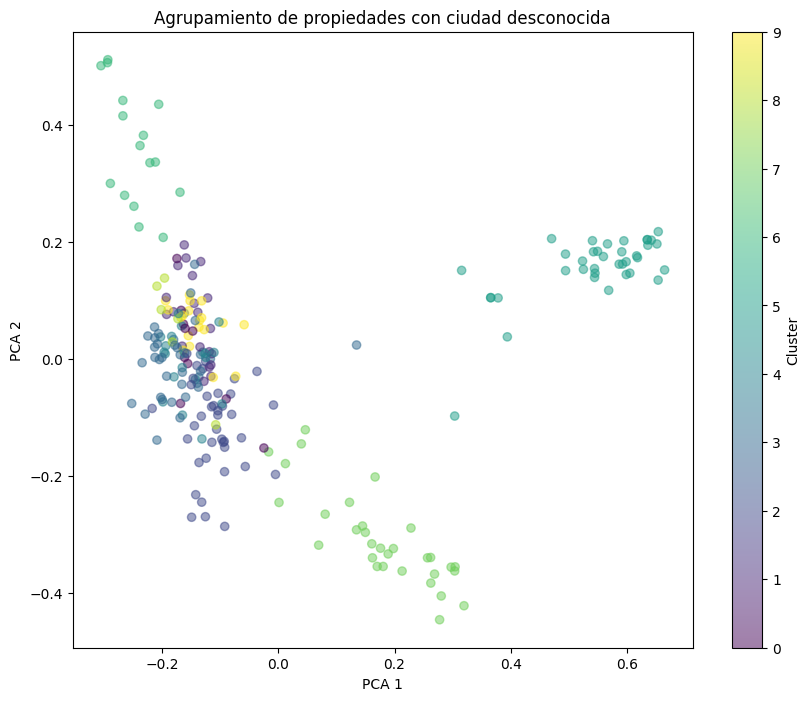


--- CLUSTER 0 ---
Número de propiedades: 10
Ubicaciones más comunes:
ubicacion
boston, buenos aires, miraflores     1
castropol, el tesoro, simesa         1
castropol, alejandria, simesa        1
castropol, simesa, el poblado        1
el tesoro, alejandria, la florida    1
Name: count, dtype: int64
Georeferencias más comunes:
georeferencia
poblado            3
trece noviembre    1
castropol          1
altos poblado      1
barrio mesa        1
Name: count, dtype: int64

--- CLUSTER 1 ---
Número de propiedades: 20
Ubicaciones más comunes:
ubicacion
loma del atravesado, las palmas, la mesa            1
san lucas, los balsos no.1, la inmaculada           1
ub. terreros, soacha, san luis                      1
el centro, la francia, terrazas de campo hermoso    1
la florida, altos del poblado, castropol            1
Name: count, dtype: int64
Georeferencias más comunes:
georeferencia
vereda planta    1
san lucas        1
trebol           1
chipre           1
tesoro           1
Name: count, 

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Filtrar solo las propiedades con ciudad desconocida
df_sin_identificar = df[df['ciudad_consolidada'] == 'desconocida'].copy()

# 2. Preparar el texto combinado
df_sin_identificar['texto_combinado'] = (
    df_sin_identificar['ubicacion'] + " " +
    df_sin_identificar['descripcion'] + " " +
    df_sin_identificar['georeferencia']
)

# 3. Vectorizar con TF‑IDF
vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer.fit_transform(df_sin_identificar['texto_combinado'])

# 4. PCA para reducir a 2 dimensiones (visualización)
pca = PCA(n_components=2, random_state=42) # Componentes principales 
X_pca = pca.fit_transform(X_tfidf.toarray())

# 5. K‑Means (5 clusters, semilla fija)
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10) # Este es el modelo de agrupamiento, número de grupos (n_clusters), semilla (random_state), # de iniciaciones (n_init)
clusters = kmeans.fit_predict(X_tfidf)
df_sin_identificar['cluster'] = clusters

# 6. Mostrar scatter de clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=clusters, cmap='viridis', alpha=0.5)
plt.title('Agrupamiento de propiedades con ciudad desconocida')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# 7. Inspeccionar cada cluster
for cluster_id in range(11):
    cluster_data = df_sin_identificar[df_sin_identificar['cluster'] == cluster_id]
    print(f"\n--- CLUSTER {cluster_id} ---")
    print(f"Número de propiedades: {len(cluster_data)}")
    print("Ubicaciones más comunes:")
    print(cluster_data['ubicacion'].value_counts().head(5))
    print("Georeferencias más comunes:")
    print(cluster_data['georeferencia'].value_counts().head(5))


Si los grupos no están claramente separados la tarea es más difícil ya que puede haber mucha superposición. En una situación como esta, se espera que un método de clustering no asigne los puntos de la intersección a su grupo de manera correcta.

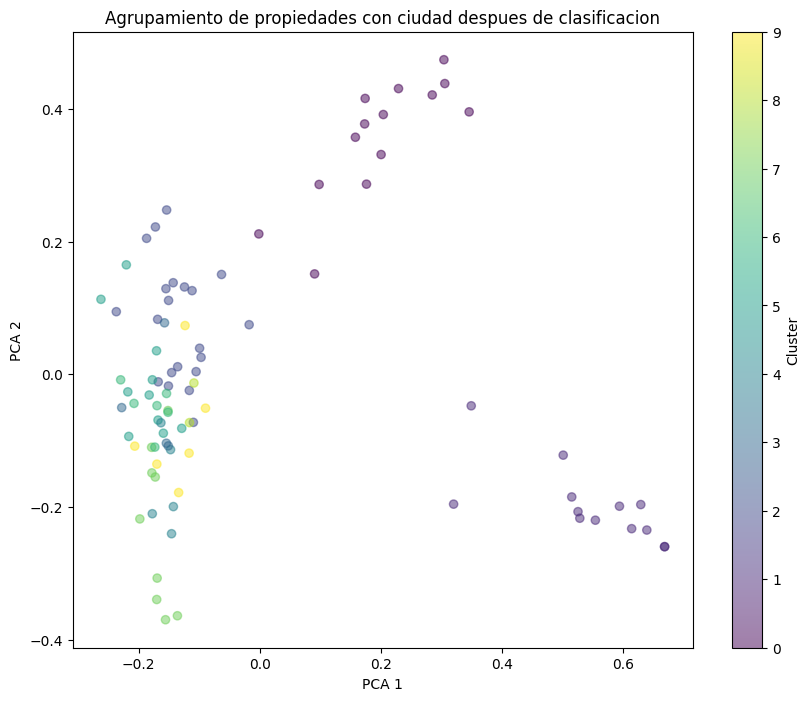


--- CLUSTER 0 ---
Número de propiedades: 14
Ubicaciones más comunes:
ubicacion
centro, fusagasuga, paseo real                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              2
los colores, san german, santa rosa de lima                                                                                                                                                                                                                                                                                                                                                                               

In [116]:

# 1. Filtrar solo las propiedades con ciudad desconocida
df_sin_identificar = df[df['ciudad_final'] == 'desconocida'].copy()

# 2. Preparar el texto combinado
df_sin_identificar['texto_combinado'] = (
    df_sin_identificar['ubicacion'] + " " +
    df_sin_identificar['descripcion'] + " " +
    df_sin_identificar['georeferencia']
)

# 3. Vectorizar con TF‑IDF
vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer.fit_transform(df_sin_identificar['texto_combinado'])

# 4. PCA para reducir a 2 dimensiones (visualización)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 5. K‑Means (5 clusters, semilla fija)
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_tfidf)
df_sin_identificar['cluster'] = clusters

# 6. Mostrar scatter de clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=clusters, cmap='viridis', alpha=0.5)
plt.title('Agrupamiento de propiedades con ciudad despues de clasificacion')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# 7. Inspeccionar cada cluster
for cluster_id in range(11):
    cluster_data = df_sin_identificar[df_sin_identificar['cluster'] == cluster_id]
    print(f"\n--- CLUSTER {cluster_id} ---")
    print(f"Número de propiedades: {len(cluster_data)}")
    print("Ubicaciones más comunes:")
    print(cluster_data['ubicacion'].value_counts().head(5))
    print("Georeferencias más comunes:")
    print(cluster_data['georeferencia'].value_counts().head(5))


In [117]:
df.head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_detectada_ubicacion,ciudad_detectada_descripcion,ciudad_detectada_georeferencia,ciudad_consolidada,ciudad_final,confianza_ciudad
0,3300000000,"envigado, loma del escobero, las palmas",4,4,2,450.0,En una de las zonas más tranquilas y exclusiva...,Casa campestre en venta,loma escobero,medellin,cali,None,medellin,medellin,0.88
1,350000000,"cn solares de la morada et vii y viii, br send...",2,3,2,100.0,"SE VENDE, Hermosa casa en el castillo Zona Jam...",Casa en venta,hacienda castillo,None,cali,None,cali,cali,1.00
2,1200000000,"la calera, la plazuela, alto de la virgen",4,8,12,5127.0,Expectacular casa-finca campestre vía Bogotá- ...,Casa campestre en venta,centro,None,bogota,None,bogota,bogota,0.75
3,194000000,"loma del atravesado, las palmas, la mesa",3,1,No encontrado,78.0,Esta encantadora casa cuenta con servicios com...,Casa en venta,vereda planta,None,None,None,desconocida,medellin,1.00
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,,Casa en venta,niza,bogota,None,None,bogota,bogota,1.00


In [118]:
print('Cantidad de datos de Medellin:', df[df['ciudad_final'] == 'medellin'].shape[0])
print('Cantidad de datos de Bogota:', df[df['ciudad_final'] == 'bogota'].shape[0])

Cantidad de datos de Medellin: 183
Cantidad de datos de Bogota: 164


In [119]:
df['ciudad_final'].value_counts()

ciudad_final
medellin        183
bogota          164
desconocida      90
cali             12
barranquilla     10
pereira           8
cartagena         4
manizales         3
pasto             2
ibague            2
cucuta            1
Name: count, dtype: int64

In [120]:
df['descripcion'] = df['descripcion'].fillna('')
df['ubicacion'] = df['ubicacion'].fillna('')
df['georeferencia'] = df['georeferencia'].fillna('')

In [121]:
spanish_stopwords = stopwords.words('spanish')

df['texto_completo'] = df['descripcion'] + " " + df['ubicacion'] + " " + df['georeferencia']
def preprocess_text(text):
    text = text.lower() # Convertir a minúsculas
    text = re.sub(r'\d+', '', text) # Eliminar números
    words = text.split() # Tokenizar por espacios (simple)
    words = [word for word in words if word not in spanish_stopwords and len(word) > 2] # Eliminar stopwords y palabras cortas
    return " ".join(words)
df['texto_procesado'] = df['texto_completo'].apply(preprocess_text)


In [123]:
from sklearn.model_selection import train_test_split

# Filtrar clases (ciudades) con muy pocas muestras si es necesario, o manejarlo con estratificación y CUIDADO en la interpretación
min_samples_per_class = 3 # Umbral mínimo de muestras por clase para el split
class_counts = df['ciudad_final'].value_counts() # Cuenta cuantas veces aparece cada clase (ciudad)
classes_to_keep = class_counts[class_counts >= min_samples_per_class].index
df_final_filtered = df[df['ciudad_final'].isin(classes_to_keep)]

if len(df_final_filtered) < len(df):
    print(f"\nSe filtraron {len(df) - len(df_final_filtered)} muestras debido a clases con menos de {min_samples_per_class} instancias.")
    df = df_final_filtered

if df.empty or df['ciudad_final'].nunique() < 2:
    print("\nNo hay suficientes datos o clases para continuar con la clasificación después del filtrado.")
    # Detener o manejar este caso apropiadamente
else:
    print(f"\nContinuando con {len(df)} muestras y {df['ciudad_final'].nunique()} clases.")

    # Variables para el modelo
    X = df['texto_procesado']
    y = df['ciudad_final']

    # Dividir los datos en entrenamiento y prueba
    # Usar stratify=y si tienes desbalance de clases y suficientes muestras por clase
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    except ValueError as e:
        print(f"Error al dividir los datos (posiblemente por clases con pocas muestras): {e}. Intentando sin estratificación.")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
    print(f"Tamaño del conjunto de prueba: {len(X_test)}")
    print(f'Clases en entrenamiento: {y_train.value_counts()}')


Continuando con 474 muestras y 8 clases.
Tamaño del conjunto de entrenamiento: 355
Tamaño del conjunto de prueba: 119
Clases en entrenamiento: ciudad_final
medellin        137
bogota          123
desconocida      67
cali              9
barranquilla      8
pereira           6
cartagena         3
manizales         2
Name: count, dtype: int64


¿Qué se estaría eliminando?: Se eliminarían todas las filas (propiedades) que pertenecen a una ciudad que aparece menos de 3 veces en el total de tus datos, por lo que estariamos trabajando nuevamente con un analisis que no tiene en cuenta todas las ciudades detectadas, esto se hace debido a que se necesita un soporte Los modelos de machine learning tienen dificultades para aprender patrones de clases con muy pocas instancias. Pueden simplemente ignorarlas o tener un rendimiento muy pobre en ellas y tambien afecta las metricas, 3 es realmente poco pero si escogemos uno mayor mas ciudades se eliminarian y la censura empeora <br>
Si usamos ciudad_consolidada tenemos el problema que se eliminan muchas clases y no nos podemos dar este lujo 

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import re
import numpy as np

In [126]:
if not df.empty and df['ciudad_final'].nunique() >= 2 and len(X_train) > 0:
    print("\n--- 2. Modelos de Clasificación por Texto ---")

    # 1. Vectorización TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) # Usar unigrams y bigrams, limitar features,
    # No se estan usando stopwords por que no sabemos que palabras son relevantes y cuales no
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    print(f"Dimensiones de la matriz TF-IDF de entrenamiento: {X_train_tfidf.shape}")
    print(f"Dimensiones de la matriz TF-IDF de prueba: {X_test_tfidf.shape}")

    # 2. Entrenamiento y Evaluación de Modelos
    models = {
        "Regresión Logística": LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', random_state=42), # C es el inverso de la regularización
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), # class_weight para desbalance, pero balanced hace un calculo de cada clase 
        "Naive Bayes Multinomial": MultinomialNB(alpha=0.1) # alpha es el suavizado de Laplace
    }

    for name, model in models.items():
        print(f"\nEntrenando {name}...")
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)

        print(f"\nResultados para {name}:")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        print("Reporte de Clasificación:")

        print(classification_report(y_test, y_pred, zero_division=0)) #, labels=unique_labels



else:
    print("\nNo se pueden ejecutar los modelos de clasificación debido a datos insuficientes o problemas en la preparación.")


--- 2. Modelos de Clasificación por Texto ---
Dimensiones de la matriz TF-IDF de entrenamiento: (355, 5000)
Dimensiones de la matriz TF-IDF de prueba: (119, 5000)

Entrenando Regresión Logística...

Resultados para Regresión Logística:
Accuracy: 0.5966
Reporte de Clasificación:
              precision    recall  f1-score   support

barranquilla       0.00      0.00      0.00         2
      bogota       0.58      0.78      0.67        41
        cali       0.00      0.00      0.00         3
   cartagena       0.00      0.00      0.00         1
 desconocida       0.00      0.00      0.00        23
   manizales       0.00      0.00      0.00         1
    medellin       0.62      0.85      0.72        46
     pereira       0.00      0.00      0.00         2

    accuracy                           0.60       119
   macro avg       0.15      0.20      0.17       119
weighted avg       0.44      0.60      0.51       119


Entrenando Random Forest...

Resultados para Random Forest:
Accuracy

# Interpretación de Resultados de Clasificación de Texto

Este análisis evalúa el desempeño de tres modelos (Regresión Logística, Random Forest y Naive Bayes Multinomial) para predecir la variable `ciudad_final` a partir de descripciones de propiedades utilizando una representación TF-IDF.

---

## Dimensiones del Conjunto de Datos

- **Entrenamiento**: (355, 5000)  
- **Prueba**: (119, 5000)  

> **Nota**: El tamaño del conjunto de prueba es moderado y existe un desbalance de clases significativo. Esto dificulta la capacidad predictiva del modelo, especialmente para clases con muy pocas muestras en el conjunto de prueba (*support*).

---

## 1. Regresión Logística

- **Accuracy**: 0.5966 (59.66%)

### Desempeño por Clase

**Clases con mejor rendimiento (F1-score > 0.50):**
- `bogota`: F1 = 0.67 (Precisión = 0.58, Recall = 0.78, Support = 41)
- `medellin`: F1 = 0.72 (Precisión = 0.62, Recall = 0.85, Support = 46)

**Clases con rendimiento nulo (F1-score = 0.00):**
- `barranquilla` (Support = 2)  
- `cali` (Support = 3)  
- `cartagena` (Support = 1)  
- `desconocida` (Support = 23)  
- `manizales` (Support = 1)  
- `pereira` (Support = 2)

### Promedios

- **Macro Avg F1**: 0.17  
- **Weighted Avg F1**: 0.51

---

## 2. Random Forest

- **Accuracy**: 0.6303 (63.03%)

### Mejoras respecto a Regresión Logística

**Clases con mejora notable:**
- `barranquilla`: F1 = 0.67 (Precisión = 1.00, Recall = 0.50, Support = 2)  
- `pereira`: F1 = 1.00 (Precisión = 1.00, Recall = 1.00, Support = 2)  
- `desconocida`: F1 = 0.20 (Precisión = 0.43, Recall = 0.13, Support = 23)

**Clases con rendimiento similar o leve mejora:**
- `bogota`: F1 = 0.67 (Precisión = 0.63, Recall = 0.71, Support = 41)  
- `medellin`: F1 = 0.73 (Precisión = 0.63, Recall = 0.87, Support = 46)

**Clases sin mejora (F1-score = 0.00):**
- `cali` (Support = 3)  
- `cartagena` (Support = 1)  
- `manizales` (Support = 1)

### Promedios

- **Macro Avg F1**: 0.41  
- **Weighted Avg F1**: 0.58

---

## 3. Naive Bayes Multinomial

- **Accuracy**: 0.6723 (67.23%)  
> *Mejor accuracy entre los tres modelos.*

### Mejores Resultados Generales

**Clases destacadas:**
- `medellin`: F1 = 0.75 (Precisión = 0.68, Recall = 0.83, Support = 46)  
- `bogota`: F1 = 0.73 (Precisión = 0.70, Recall = 0.76, Support = 41)  
- `desconocida`: F1 = 0.41 (Precisión = 0.50, Recall = 0.35, Support = 23)  
- `barranquilla`: F1 = 0.67 (Precisión = 1.00, Recall = 0.50, Support = 2)  
- `pereira`: F1 = 1.00 (Precisión = 1.00, Recall = 1.00, Support = 2)

**Clases sin mejora (F1-score = 0.00):**
- `cali` (Support = 3)  
- `cartagena` (Support = 1)  
- `manizales` (Support = 1)

### Promedios

- **Macro Avg F1**: 0.44  
- **Weighted Avg F1**: 0.65  
> *Mejor F1 ponderado entre los tres modelos.*

---

## Conclusiones Generales

- **Naive Bayes Multinomial** es el modelo con **mejor desempeño general**, obteniendo el mayor *accuracy* (67.23%) y el F1-score ponderado más alto (0.65).
- El **desbalance de clases** es un factor crítico. Las clases `bogota` y `medellin`, que tienen mayor número de muestras en el conjunto de prueba, obtienen consistentemente mejores F1-scores en todos los modelos.
- Las clases con muy pocas muestras (`cali`, `cartagena`, `manizales`) no son predichas correctamente por ninguno de los modelos (*F1 = 0.00*). Esto es esperable, ya que los modelos no tienen suficientes ejemplos para aprender sus características.
- La clase `desconocida` también presenta un desafío, aunque Naive Bayes muestra una capacidad limitada para identificar algunas de estas instancias (F1 = 0.41).
- **Random Forest** y **Naive Bayes** logran un rendimiento perfecto (F1=1.00) para la clase `pereira` y un buen F1 (0.67) para `barranquilla`, a pesar de su bajo *support*. Esto podría deberse a:
  - Casualidad por el bajo número de muestras.
  - Características textuales muy distintivas en esas instancias.

---

## Recomendaciones

- Explorar técnicas para mejorar el rendimiento en clases minoritarias:
  - **Sobremuestreo** (ej. SMOTE, aunque es más complejo en datos de texto).
  - **Recopilación de más datos** para esas clases.
- Considerar **agrupar clases muy pequeñas** en una categoría “otros” si la distinción individual no es crucial.
- Interpretar el rendimiento con **cautela para clases con bajo support**, ya que las métricas pueden no ser robustas.


In [127]:
if not df.empty and len(X) > 0 : # X se definió antes de la división train/test
    print("\n--- 3. Modelado de Tópicos con LDA ---")
    # Usaremos todo el texto procesado (X) para LDA, ya que es no supervisado

    # 1. Vectorización con CountVectorizer para LDA
    # Puedes experimentar con min_df y max_df para filtrar términos muy raros o muy comunes
    count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=spanish_stopwords, ngram_range=(1,1))
    X_counts = count_vectorizer.fit_transform(X) # X es df['texto_procesado']

    if X_counts.shape[0] > 0 and X_counts.shape[1] > 0:
        # 2. Entrenamiento del Modelo LDA
        num_topics = 5 # Define el número de tópicos que quieres descubrir. Esto es un hiperparámetro.
                      # Si tienes pocas ciudades o tipos de descripciones, un número menor es mejor.
                      # Si tienes muchos datos y variedad, puedes aumentarlo.
        if X_counts.shape[0] < num_topics:
            print(f"Advertencia: El número de muestras ({X_counts.shape[0]}) es menor que el número de tópicos ({num_topics}). Reduciendo num_topics.")
            num_topics = max(1, X_counts.shape[0] // 2) # Ajustar para que sea factible


        if num_topics > 0:
            lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, learning_method='online')
            lda.fit(X_counts)

            # 3. Interpretación de Tópicos
            print(f"\nPrincipales palabras por tópico (LDA con {num_topics} tópicos):")
            feature_names = count_vectorizer.get_feature_names_out()
            for topic_idx, topic in enumerate(lda.components_):
                top_words_indices = topic.argsort()[:-10 - 1:-1] # Top 10 palabras
                top_words = [feature_names[i] for i in top_words_indices]
                print(f"Tópico #{topic_idx}: {', '.join(top_words)}")

            # 4. Asignación de Tópicos a Documentos
            # Esto te da una matriz donde cada fila es un documento y cada columna es la probabilidad de ese tópico para ese documento.
            topic_distributions = lda.transform(X_counts)
            df[f'topico_lda_dominante'] = topic_distributions.argmax(axis=1)
            print("\nPrimeras 10 propiedades con su tópico LDA dominante:")
            print(df[['descripcion', 'ciudad_final', 'topico_lda_dominante']].head(10))


        else:
            print("No se pudo ejecutar LDA debido a un número de tópicos inválido (<=0) después del ajuste.")

    else:
        print("No se puede ejecutar LDA: la matriz de conteo está vacía o tiene dimensiones inválidas.")
else:
    print("\nNo se puede ejecutar el modelado de tópicos debido a datos insuficientes.")


--- 3. Modelado de Tópicos con LDA ---

Principales palabras por tópico (LDA con 5 tópicos):
Tópico #0: bodega, piso, altura, acceso, excelente, sector, arriendo, centro, área, oficinas
Tópico #1: casa, cuenta, espacio, zona, ideal, baños, baño, área, comodidad, además
Tópico #2: sabaneta, doctora, amigos, vegas, corresponde, area, estrella, caldas, catastral, unidad
Tópico #3: villa, estrenar, variados, confortables, amplios, espacios, galapa, internos, castilla, centro
Tópico #4: cocina, lugar, cuenta, zona, sala, casa, comedor, encontrar, san, habitaciones

Primeras 10 propiedades con su tópico LDA dominante:
                                         descripcion  ciudad_final  \
0  En una de las zonas más tranquilas y exclusiva...      medellin   
1  SE VENDE, Hermosa casa en el castillo Zona Jam...          cali   
2  Expectacular casa-finca campestre vía Bogotá- ...        bogota   
3  Esta encantadora casa cuenta con servicios com...      medellin   
4                            

## Interpretación del Modelado de Tópicos con LDA

El modelo LDA se configuró para identificar **5 tópicos latentes** en las descripciones de propiedades inmobiliarias. A continuación, se presenta una interpretación detallada de los tópicos generados y de su asignación a las primeras propiedades.

---

### Principales Palabras por Tópico

- **Tópico 0**: *bodega, piso, altura, acceso, excelente, sector, arriendo, centro, área, oficinas*  
  **Interpretación**: Este tópico está claramente asociado con propiedades comerciales o industriales, como **bodegas u oficinas**, destacando características como altura, ubicación céntrica y uso para arriendo.

- **Tópico 1**: *casa, cuenta, espacio, zona, ideal, baños, baño, área, comodidad, además*  
  **Interpretación**: Tópico general de **vivienda residencial**, con énfasis en el confort, número de baños y amplitud del espacio. Es un lenguaje común en anuncios de casas.

- **Tópico 2**: *sabaneta, doctora, amigos, vegas, corresponde, area, estrella, caldas, catastral, unidad*  
  **Interpretación**: Este tópico parece estar influenciado por elementos **geográficos y sociales**. Palabras como “sabaneta”, “estrella”, “caldas” y “vegas” apuntan a una localización específica en Antioquia. Es posible que capte descripciones centradas en municipios cercanos y aspectos legales (e.g., "catastral").

- **Tópico 3**: *villa, estrenar, variados, confortables, amplios, espacios, galapa, internos, castilla, centro*  
  **Interpretación**: Este tópico describe propiedades **nuevas o en zonas emergentes**, usando términos como “estrenar” y “confortables”. También incluye nombres de barrios o zonas como “galapa” y “castilla”, lo que podría indicar cierta orientación **regional o de expansión urbana**.

- **Tópico 4**: *cocina, lugar, cuenta, zona, sala, casa, comedor, encontrar, san, habitaciones*  
  **Interpretación**: Muy similar al Tópico 1, pero con enfoque más detallado en **las partes internas de la vivienda**, como cocina, comedor, sala y habitaciones. Puede ser un subgrupo dentro de las viviendas residenciales, más orientado a la **descripción de la distribución interna**.

---

### Asignación de Tópicos a Propiedades

Análisis de las **10 primeras propiedades** según su tópico dominante:

| Índice | Ciudad        | Tópico Dominante |
|--------|---------------|------------------|
| 0      | Medellín      | 1                |
| 1      | Cali          | 1                |
| 2      | Bogotá        | 1                |
| 3      | Medellín      | 4                |
| 4      | Bogotá        | 1                |
| 5      | Medellín      | 1                |
| 6      | Cali          | 1                |
| 7      | Barranquilla  | 1                |
| 8      | Desconocida   | 4                |
| 9      | Medellín      | 1                |

> Observación: **7 de las 10 propiedades** están asociadas al **Tópico 1**, lo que confirma su prevalencia como tópico dominante en descripciones de tipo residencial general.

---

## Conclusiones del Modelado LDA

- **Tópicos interpretables y distintos**: El modelo logró diferenciar entre categorías como:
  - Propiedades **comerciales/industriales** (Tópico 0)
  - Vivienda **residencial general** (Tópico 1)
  - Regiones **específicas o sub-urbanas** (Tópico 2)
  - Propiedades **nuevas o en expansión** (Tópico 3)
  - Detalles **internos del hogar** (Tópico 4)

- **Dominancia del Tópico 1**: Refleja que la mayoría de las propiedades en el conjunto de datos se describen con un lenguaje residencial tradicional.

- **Presencia de información geográfica**: Varios tópicos (especialmente el 2 y 3) contienen **referencias a municipios, barrios o zonas específicas**, lo que sugiere que el LDA es capaz de captar **sesgos geográficos implícitos**.

- **Complemento para clasificación supervisada**: La probabilidad de pertenencia a cada tópico puede ser usada como **nueva variable explicativa** en modelos de clasificación de ciudad, mejorando el rendimiento predictivo.

- **Revisión del número de tópicos**: Aunque 5 tópicos permiten una buena separación temática, **aumentar o disminuir este número** podría afinar la granularidad semántica, dependiendo del objetivo final del análisis.

---


In [128]:
df_final = df.copy()
df_final.columns.tolist()
'''
Columnas relevantes para el modelo:
precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_mejorada'
'''

df_final = df_final[['precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area', 
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_final']]

df_final.head(10)


# Guardar el DataFrame final en un archivo CSV
df_final.to_csv('propiedades_limpias.csv', index=False, encoding='utf-8-sig')


Que nos falto? Outliers y datos no validos